In [3]:
%%capture
from stylometry import *

import numpy as np
from copy import copy
from joblib import Parallel,delayed
import time
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import  Activation, Dense, Input
from keras.optimizers import RMSprop
from sklearn.utils import shuffle

In [2]:
# prepare book text
with open('books/art_and_ritual.txt') as f:
    corpus_a = f.read()
with open('books/golden_bough.txt') as f:
    corpus_g = f.read()
    
corpus_a = clean(corpus_a)
corpus_g = clean(corpus_g)

# split last tenth of each book for test data
corpus_a_test = corpus_a[int(.9*len(corpus_a)):]
corpus_g_test = corpus_g[int(.9*len(corpus_g)):]
corpus_a = corpus_a[:int(.9*len(corpus_a))]
corpus_g = corpus_g[:int(.9*len(corpus_g))]

In [21]:
import numpy as np
from copy import copy
from joblib import Parallel,delayed
import time
from matplotlib import pyplot as plt
from stylometry import bigrams

mergechoices=['+','-']#,'/','\\']

def merge2(a,b,j):
    if j=='+':
        return a+b
    if j=='-':
        return a-b
    if j=='/':
        return a/(b+1.001)
    if j=='\\':
        return b/(a+1.001)
    
def risc(text,k,j):
    A = 0
    for ki,ji in zip(k,j):
        a = int(ki in text)
        A = merge2(A,a,ji)
    return A

def mutate(k,j,bigs):
    k1,j1=copy(k),copy(j)
    h = np.random.choice([1,2]+[3]*20)
    if h==0:
        2-2
    if h==1:
        k1+=[np.random.choice(bigs)]
        j1+=[np.random.choice(mergechoices)]
    if h==2:
        if len(k)>0:
            s = np.random.choice(len(k))
            k1[s] = np.random.choice(bigs)
            j1[s] = np.random.choice(mergechoices)    
    if h==3:
        if len(k)>1:
            s = np.random.choice(len(k))
            k1 = k1[:s]+k1[s+1:]
            j1 = j1[:s]+j1[s+1:]
    return k1,j1

def generate_samples(corpus1,corpus2,num=100,ls=1000):
    T1=[]
    T2=[]
    ban=min(len(corpus1),len(corpus2))
    for l in range(num):
        ko=np.random.randint(ban-ls)
        t=corpus1[ko:ko+ls]
        T1.append(t)
        t=corpus2[ko:ko+ls]
        T2.append(t)
    return T1,T2

def score(k,j,T1,T2):
    return np.mean([np.sign(risc(t,k,j)) for t in T1])-\
         np.mean([np.sign(risc(t,k,j)) for t in T2])

def update_or_no(k,j,T1,T2,bigs):
    k1,j1=mutate(k,j,bigs)
    m1 = score(k1,j1,T1,T2)
    m0 = score(k,j,T1,T2)
    if m1>=m0:
        return k1,j1,m0
    else:
        return k,j,m0
    
'''def evolve(k,j,num=1000):
    MS=[]
    for h in range(num):
        k,j,m0 = update_or_no(k,j,T1,T2)
        MS.append(m0)
    return k,j,MS'''

def evolve2(kj,T1,T2,bigs):
    k,j=kj[0],kj[1]
    MS=[]
    for h in range(1000):
        k,j,m0 = update_or_no(k,j,T1,T2,bigs)
        MS.append(m0)
    return k,j,MS

def reckon(K,J,T1,T2):
    ks=1
    S=[score(k,j,T1,T2) for k,j in zip(K,J)]
    S1 = list(np.argsort(S)[-ks:])+\
         list(np.argsort(S)[-len(S)+ks:])
    K1=[K[s] for s in S1]
    J1=[J[s] for s in S1]
    return K1,J1

def pluice(k,j):
    kp = [ki for ki,ji in zip(k,j) if ji=='+']
    km = [ki for ki,ji in zip(k,j) if ji=='-']
    return '+ ('+', '.join(kp)+') - ('+', '.join(km)+')'


def breed(corpus1,corpus2,
          Npop=30,Ngen=20,
          workers=10,
          display=False):
    
    bigs = corpus1.split()+corpus2.split()
    bigs+=bigrams(bigs)
    
    K=[list(np.random.choice(bigs,1)) for i in range(Npop)]
    J = [list(np.random.choice(mergechoices,1)) for i in range(Npop)]
    
    MS = [[] for i in range(Npop)]
    for ii in range(Ngen):
        start=time.time()
        T1,T2=generate_samples(corpus1,corpus2)
        KJ=list(zip(K,J))
        KJM=Parallel(n_jobs=workers)(
            delayed(evolve2)(x,T1,T2,bigs)
            for x in KJ)
        K = [o[0] for o in KJM]
        J = [o[1] for o in KJM]
        M = [o[2] for o in KJM]
        MS = [M+m for M,m in zip(MS,M)]
        K,J = reckon(K,J,T1,T2)
        end=time.time()
        if display:
            print(ii,round(end-start,1),
              np.random.choice([T1[0],T2[0]])[:50])
    if display:
        for m in MS:
            plt.plot(np.arange(len(m)),(np.array(m)+2)/4)
        plt.xlabel('epoch')
        plt.ylabel('performance')
        plt.ylim(.5,1)
        plt.show()
        for k,j in zip(K,J):
            print(pluice(k,j)+'\n')
    return K,J

0
0 104.7 rom the experience of the sea fog for the moment i
1 104.6 ssion the original text has been reprinted without
2 108.3  then was the object of the panathenaic procession
3 106.4 of moral risks from which the artist is quâ artist
4 108.1 he statues of the greek gods are olympian in spiri
5 108.6 annual holy bulls once perceived then remembered g
6 108.4 rn will go on foaming till the hour of high water 
7 107.4 n of the god for they represented him in pictures 
8 107.8 on chapter the golden bough chapter farewell to ne
9 108.6 ents the beauty of the greek then certainly there 


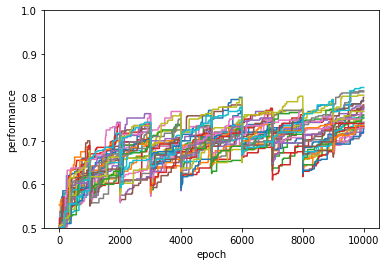

+ (but, drama, word, who not, fact the, specially for) - (far, water, killed, magic, believe, been, cook, coveted)

+ (no, real, festival, comes a, the rise, blood, midsummer, encamping, end of) - (been, thus, of the, system, as he, girl out, ceremony)

+ (then, have, resurrection, old the, might, the end, be a) - (man, been, assume, or imitative, she, tribes whose)

+ (not, represent, rites of, air and, once, or magical) - (fire, prevent, magic, until, fall, short, ever)

+ (ritual, god, assemble, we have) - (while, itself an, law, been, or in, the same, their enemies)

+ (real, his rites, to see, have seen, not a, image of, dancing, earthen, our imagination, solemn, contemplation) - (man, mother, alqamar)

+ (not, the greek, first, again, feel, driven) - (every, commonly, their, fall, that if, time, indians, will)

+ (greek, a rite, sense, but, the sacrifice) - (the, generally, away, stop, husbands, right)

+ (clear, ram, moment, day of, dithyrambs to, become) - (which, suppose, down

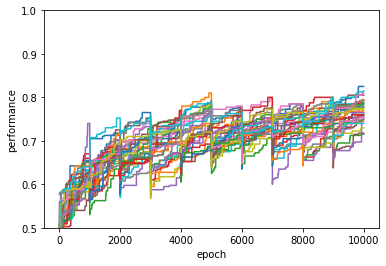

+ (drama, is the, there, heat, act, but, figures of, consented to) - (which, serve, who, power, of similar, individuals, supposed)

+ (first, but, rites, completely, when an) - (water, magical, rice, west, that the, influences that)

+ (drama, not, material, there, abstract, next, in fact, sense but) - (by, their, over, litter)

+ (day, life, only) - (while, thus, according, by means, used, great a, new south)

+ (but, come, now, custom is, gods, described, was to) - (of, supposed to, january, at their, enquirer, part of, has already, man is)

+ (not, emotion, rites, range, ritual, osiris) - (by, water, were, way of, effigy, in her)

+ (but, there, that is, of roman, holy) - (which, positive, grove, to it, part, person who)

+ (motion, then, art is, festival, there is, action, dithyramb) - (by, put, time the, soul, natives, cases the, the isle)

+ (ritual, life, another, longing, year by, a sort, see the, the image) - (which, slowly in, the corn, disease, at this, killed)

+ (but, only

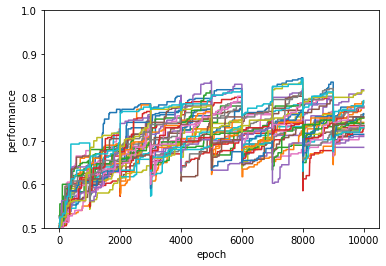

+ (but, is the, the spring, ritual) - (which, while, power, charm, among the, the view, enemies, burn)

+ (life, there, act, then the, the old, spring and, were the, the causal) - (a, right, power, fire, by the, and throw, so hard)

+ (the, dance, this, material, spirit, return, amount of) - (which, who, in the, these, to eat, at if)

+ (ritual, but, the may, image, decked with, held, sir james) - (lie, burning, on the, you would, had also, whereas, as they)

+ (the, burial, image, dance, red and) - (homoeopathic, being, hardly, supposed, which, the eggs, parts, laid, supposed)

+ (we have, life, rite, the outset, us now) - (which, a longer, him from, crops, thus, indonesians naturally)

+ (festival, ritual, spring, out of, we can) - (which, kings, works, kindle)

+ (he, spring, resurrection, we have, seen, of that, down on) - (a, by, while, in order, far, kings, the corn, occur)

+ (we have, emotion, the bear, that is, the artist, because the, fashion, up the) - (the water, a man, fir

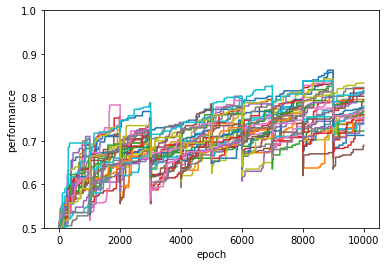

+ (athens, dionysos, ritual, but, in with, the new, think, festival, man in, weapon was) - (the, supposed, the public, on the, is said, would be, intention)

+ (not, of life, primitive, drama, rise, it were, people s) - (of the, thus, fields, were)

+ (da, but, brought, centre, of a) - (their, a, them)

+ (but, the, chose, they are, clear, ram) - (a, fire, thus, who, and that)

+ (there, come, spring festival, passage of, subject) - (belief, if the, been, in order, mother, scatter the, great peplos)

+ (there, greek, would the, earth to, come to) - (by, in order, system, purpose of, days in, power)

+ (may and, to, threshing, struck, osiris, ram) - (on the, rule, supposed, fire, which, step)

+ (but, it will, with stones) - (supposed, thus, while, string, black, heavy, observe, setting, distinction)

+ (winter, rome, it is, but the, at athens, again, it was) - (man, that if, supposed, belief, repair, sit, rice)

+ (and he, rome, then, we shall, of all, more, already, out of, faith in) 

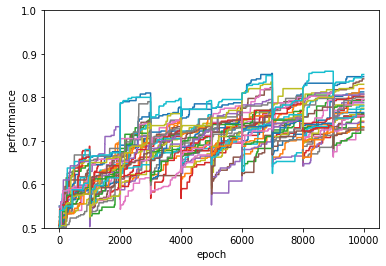

+ (but, ritual, dionysos, moment, first, cups, dance but, the people, villages, music) - (of the, magic, water, power, reasons, inherited from)

+ (out, emotion, the figure, acted, whole) - (been, belief that, who, along, thus, used, it might, blood)

+ (but, but, all this) - (of, while, and sometimes, shower, change, to their, murmur, weakness)

+ (not, the, loose, out of, enhanced) - (supposed to, the, fire, who, animal, have been, priest, you are, divinity, the custom, offering, in his)

+ (copy, the may, but, them thought) - (priesthood, practice, disease, whereof, on the, conjecture, the same)

+ (now, stage, it is, itself, god, is in, human life) - (practice, in, priest, which he, those, the subject)

+ (dance, the greek, another, there, to clotilde) - (to the, artemis at, supposed to, gate, low and, mother, among, purpose, constructed)

+ (but, ritual, what, down) - (of the, and practice, by, spittle and)

+ (winter, dance, we are, out of, villages, the greeks, feast a, the gree

In [34]:
KS,JS=[],[]
for kage in range(5):
    print(kage)
    K1,J1 = breed(corpus_a,corpus_g,Npop=30,Ngen=10,display=True)
    KS+=K1
    JS+=J1

In [44]:
%%time
# generate samples from books
num_samps = 1000
len_samps = 1000
num_samps_test = 100
num_features = 500

la = len(corpus_a)
lg = len(corpus_g)

bag_a = [corpus_a[k:k+len_samps] for k in 
          np.random.randint(0,la-len_samps,num_samps)]
bag_g = [corpus_g[k:k+len_samps] for k in 
          np.random.randint(0,lg-len_samps,num_samps)]

# generate features from samples
words_a = ' '.join(bag_a).split()
words_g = ' '.join(bag_g).split()
words_a += bigrams(words_a)
words_g += bigrams(words_g)

features = generate_features_from_words(words_a,words_g, 
                                        num_features)

#features_bi = generate_features_from_words(bigrams(words_a),
#                                         bigrams(words_g),
#                                         num_features)

#features = list(itertools.chain(*zip(features,features_bi)))

# generate test samples
lat = len(corpus_a_test)
lgt = len(corpus_g_test)

bag_at = [corpus_a_test[k:k+len_samps] for k in 
          np.random.randint(0,lat-len_samps,num_samps_test)]
bag_gt = [corpus_g_test[k:k+len_samps] for k in 
          np.random.randint(0,lgt-len_samps,num_samps_test)]


# print top stylometric features
print(' | '.join(features[:20]+['...']+features[-20:]))

the | to | in | of | by | which | of the | on | who | corn | their | with | to the | his | in the | king | they | been | on the | them | ... | drama | rite | what | greek | spring | dance | it is | this | us | our | that | life | it | and | ritual | not | but | art | we | is
CPU times: user 276 ms, sys: 4.14 ms, total: 280 ms
Wall time: 279 ms


(array([ 3.,  1.,  3.,  8., 14., 13., 23., 23.,  9.,  3.]),
 array([-147. , -111.3,  -75.6,  -39.9,   -4.2,   31.5,   67.2,  102.9,
         138.6,  174.3,  210. ]),
 <a list of 10 Patch objects>)

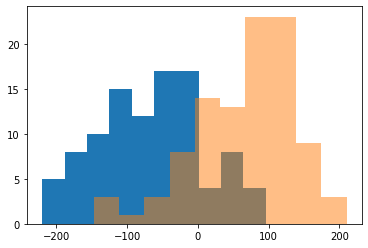

In [35]:
plt.hist([np.sum([risc(b,k,j) for k,j in zip(KS,JS)]) for b in bag_gt])
plt.hist([np.sum([risc(b,k,j) for k,j in zip(KS,JS)]) for b in bag_at],alpha=.5)

In [47]:
np.array([[risc(b,k,j) for k,j in zip(KS,JS)]
         for b in bag_a+bag_g])

array([[ 1, -1,  2, ...,  1,  1,  2],
       [ 0, -1, -1, ...,  0,  0,  0],
       [-1,  0, -3, ...,  0,  1,  1],
       ...,
       [-1, -1,  0, ..., -1,  0, -1],
       [ 0, -2,  1, ..., -1,  0,  0],
       [-4, -1, -2, ..., -3, -3, -3]])

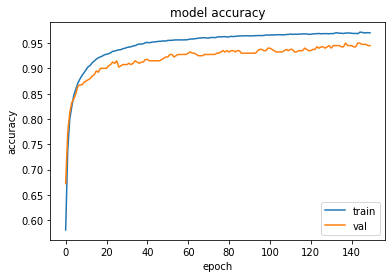

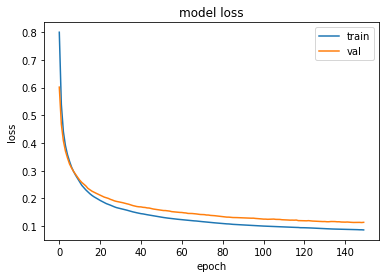

test accuracy: 0.905
CPU times: user 9.3 s, sys: 103 ms, total: 9.41 s
Wall time: 7.76 s


In [53]:
%%time
# train single dense layer
# create feature vectors
X_train = np.array([[risc(b,k,j) for k,j in zip(KS,JS)]
                    for b in bag_a+bag_g])

y_train = np.array([[0,1] for i in bag_a]+[[1,0] for i in bag_g])

X_test = np.array([[risc(b,k,j) for k,j in zip(KS,JS)]
         for b in bag_at+bag_gt])

y_test = np.array([1 for i in bag_at]+[0 for i in bag_gt])

X_train, y_train = shuffle(X_train,y_train,random_state=1305)


def sdl(in_size,out_size):
    inputs = Input(name='inputs',shape=[in_size])
    layer = Dense(out_size)(inputs)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = sdl(X_train.shape[1],2)

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train,y_train,batch_size=256,epochs=150,
          validation_split=0.1,verbose=0)
y_pred = np.argmax(model.predict(X_test),axis=1)
history_plot(history)
print('test accuracy:',np.mean(y_test==y_pred))